# Interactive dEB light curve viewing tool

In [10]:
from pathlib import Path
import re

import numpy as np
import astropy.units as u
import lightkurve as lk

#%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from libs import pipeline

### Select your target
The `search_term` can be the well known object name or a TIC identifier (format "TIC #########").

For details of the supported mission, author and exptime search arguments see the lightkurve
documentation for
[seach_lightcurve()](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.search_lightcurve.html#lightkurve.search_lightcurve),
and for details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download)


In [11]:
target = "CW Eri"
search_term = "V* CW Eri"       # "TIC 98853987"
download_dir = Path.cwd() / ".cache" / re.sub(r"[^\w\d]", "-", target.lower())
                    
# Search parameters
mission         = "TESS"        # "TESS" or "HLSP
author          = "SPOC"        # "SPOC" or "TESS-SPOC"
exptime         = "short"       # "long", "short", "fast" or numeric value (s)

flux_column     = "sap_flux"    # "sap_flux" or "pdcsap_flux"
quality_bitmask = "default"     # "hardest", "hard", "default" or a bitmask

### Review Target Information and refine the search

In [12]:
results = lk.search_lightcurve(search_term, mission=mission, author=author, exptime=exptime)

fmt = "{0}, {1}, author={2}, target={3}, exptime={4}"
checkboxes = [Checkbox(value=True,
                       description=fmt.format(r.mission[0], r.year[0], r.author[0], r.target_name[0], r.exptime[0]),
                       layout=widgets.Layout(width="50%"))
              for r in results]
display(VBox(children=checkboxes))

#### Select the sectors

In [13]:
selections = [checkboxes[i].value for i in range(len(checkboxes))]
sectors = [row["sequence_number"] for row, check in zip(results.table, selections) if check]

### Download and plot the light curves of the chose sectors

In [14]:
lcs = pipeline.find_lightcurves(search_term, download_dir, sectors, mission, author,
                                exptime, flux_column, quality_bitmask, False, True)

Searching for light curves based on; search term=V* CW Eri, sectors=[4, 31], mission=TESS, author=SPOC and exptime=short
Looking for previously downloaded fits within /home/steveo/projects/main/platodebcat/.cache/cw-eri
Found 2 existing fits matching mission and author criteria
Found the required 2 fits file(s) meeting the TIC, sector & exptime criteria. Will load the requested light curves from these.


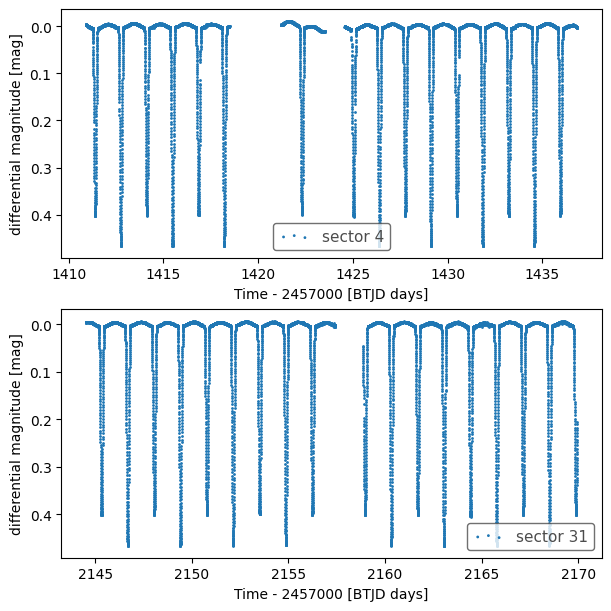

In [15]:
fig, axes = plt.subplots(figsize=(6, 3*len(lcs)), ncols=1, nrows=len(lcs), constrained_layout=True)

axes = [axes] if isinstance(axes, Axes) else axes.flatten()
for ax, lc in zip(axes, lcs):
    lc["delta_mag"] = u.Quantity(-2.5 * np.log10(lc.normalize().flux.value) * u.mag)
    lc.scatter(column="delta_mag", ax=ax, label=f"sector {lc.meta['SECTOR']}",
               ylabel="differential magnitude [mag]")
    ax.invert_yaxis()
plt.show()